In [1]:
import cellrank as cr
import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2
import warnings
warnings.simplefilter("ignore", category=UserWarning)
import config as general_paths
import os
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [3]:
adata_path = os.path.join(input_path,'ad_subset.h5ad')

In [4]:
adata = ad.read_h5ad(adata_path)

In [5]:
adata

AnnData object with n_obs × n_vars = 399 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'hvg', 'iroot', 'log1p', 'louvain', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.2_sizes', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r0.5_colors', 'louvain_r1.0_colors', 'louvain_r1.0_sizes', 'louvain_r1_colors', 'louvain_r2.0_colors', 'louvain_r2.5_colors', 'louvain_r

In [6]:
SELECTED_LOUVAIN = 'louvain_r0.2'
CLUSTER_OF_ORIGIN = "0"

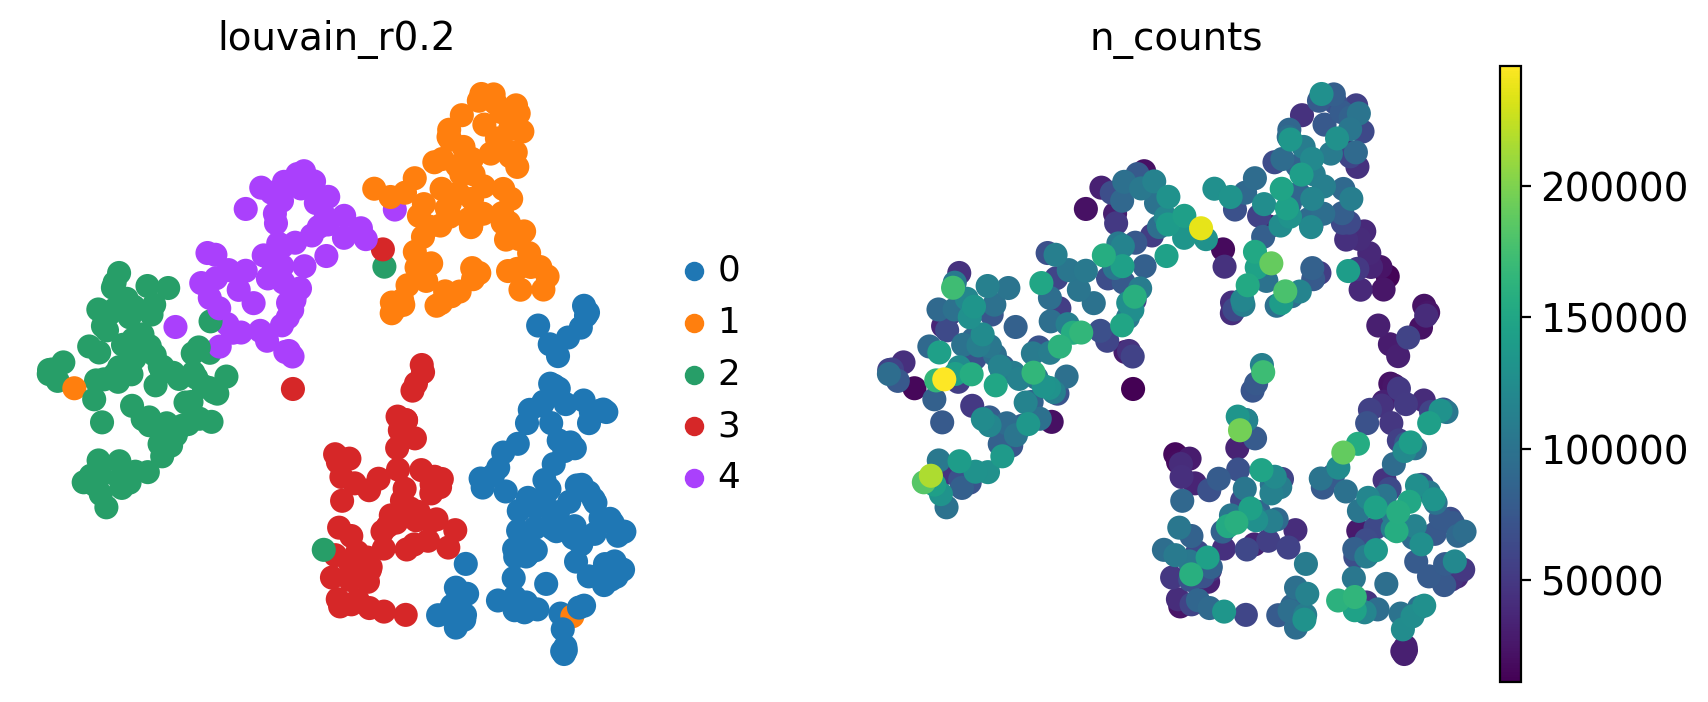

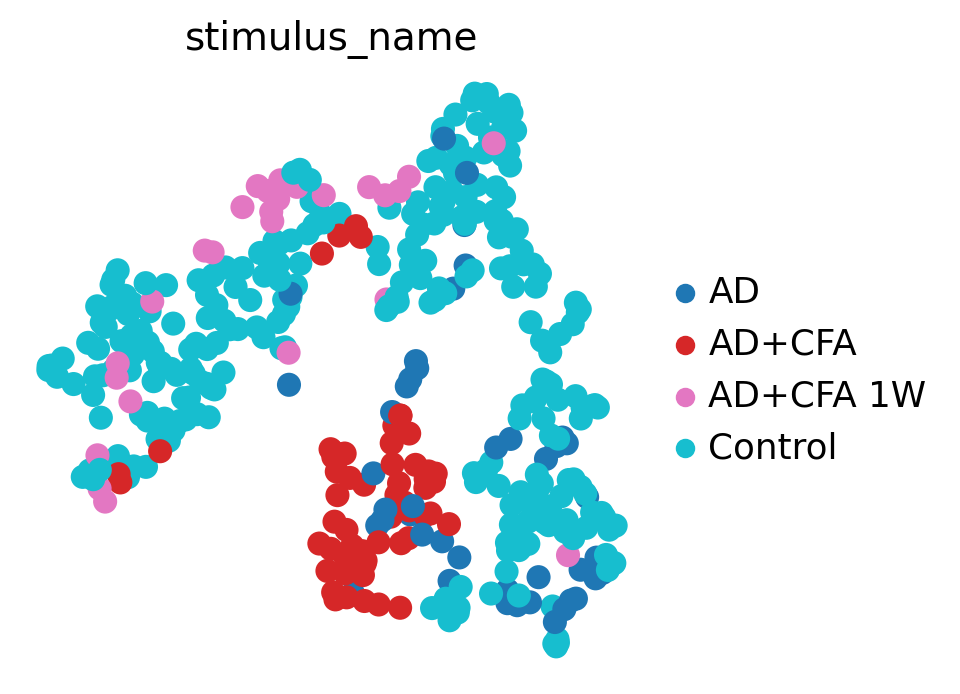

In [7]:
# Visualize this data 
sc.pl.embedding(adata, basis="X_umap", color=[SELECTED_LOUVAIN, "n_counts"])
sc.pl.umap(adata, color=['stimulus_name'], groups=['AD','AD+CFA','AD+CFA 1W','Control'], use_raw=False)

# Set up a kernel
use the PseudotimeKernel which biases k-NN graph edges to point into the direction of increasing pseudotime

In [8]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="n_counts")

In [9]:
pk

PseudotimeKernel[n=399]

In [10]:
# use this kernel to compute a cell-cell transition_matrix
pk.compute_transition_matrix()

Computing transition matrix based on pseudotime


100%|██████████| 399/399 [00:00<00:00, 3609.95cell/s]


    Finish (0:00:00)


PseudotimeKernel[n=399, dnorm=False, scheme='hard', frac_to_keep=0.3]

In [11]:
pk

PseudotimeKernel[n=399, dnorm=False, scheme='hard', frac_to_keep=0.3]

# Random Walks
To get a first impression of the cellular dynamics in this dataset, we can simulate random walks on the Markov chain implied by the transition matrix, starting from cluster 1 (? AD stimulus), and visualize these in the umap embedding.

Black and yellow dots indicate random walk start and terminal cells, respectively.

This method simulates random walks on the Markov chain defined though the corresponding transition matrix. The method is intended to give qualitative rather than quantitative insights into the transition matrix. Random walks are simulated by iteratively choosing the next cell based on the current cell’s transition probabilities

Simulating `100` random walks of maximum length `100`


100%|██████████| 100/100 [00:00<00:00, 143.89sim/s]

    Finish (0:00:00)


Plotting random walks


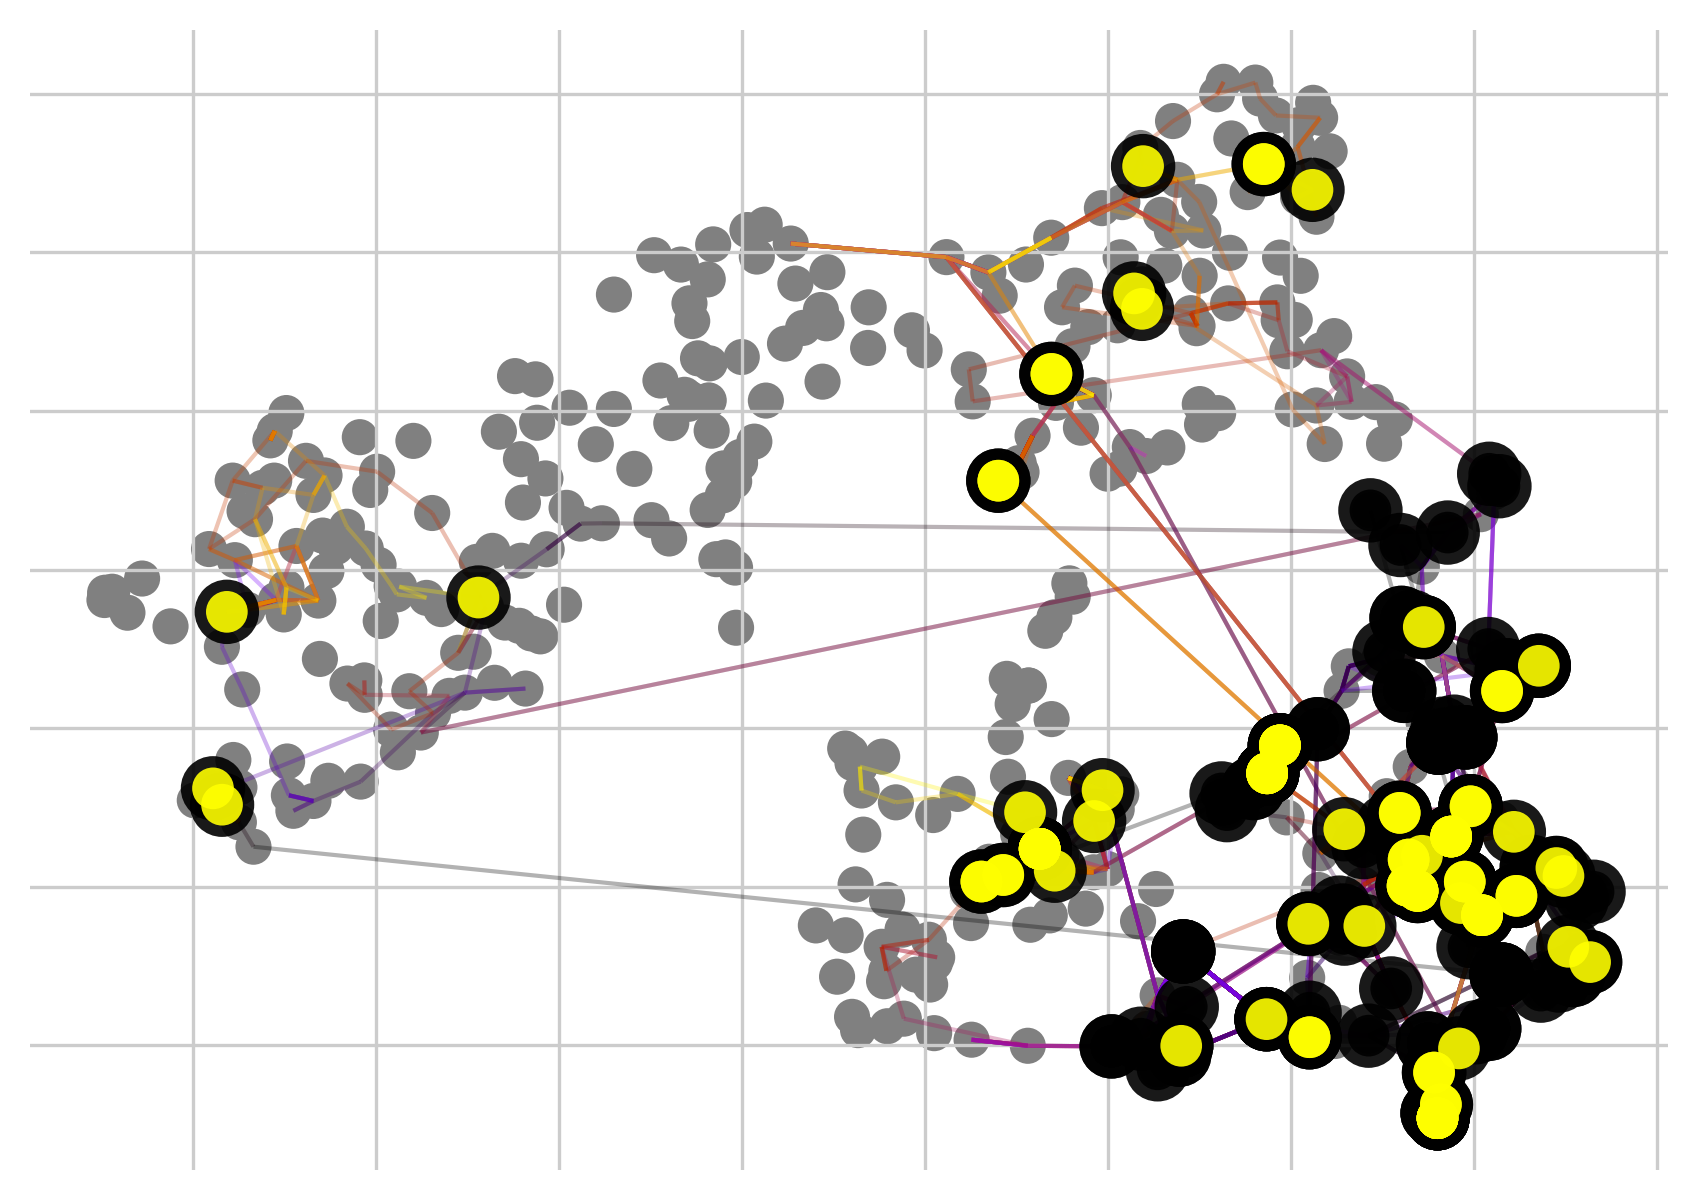

In [12]:
rcParams['figure.figsize']=(7,5)
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={SELECTED_LOUVAIN: CLUSTER_OF_ORIGIN},
    basis="X_umap",
    legend_loc="bottom",
    dpi=150,
)

# Combining different kernels

Any two kernels can be globally combined via a weighted mean. To demonstrate this, let’s set up an additional cellrank.kernels.ConnectivityKernel, based on gene expression similarity.

In [13]:
from cellrank.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [14]:
ck

ConnectivityKernel[n=399, dnorm=True, key='connectivities']

Simulating `100` random walks of maximum length `100`


100%|██████████| 100/100 [00:00<00:00, 127.79sim/s]

    Finish (0:00:00)


Plotting random walks


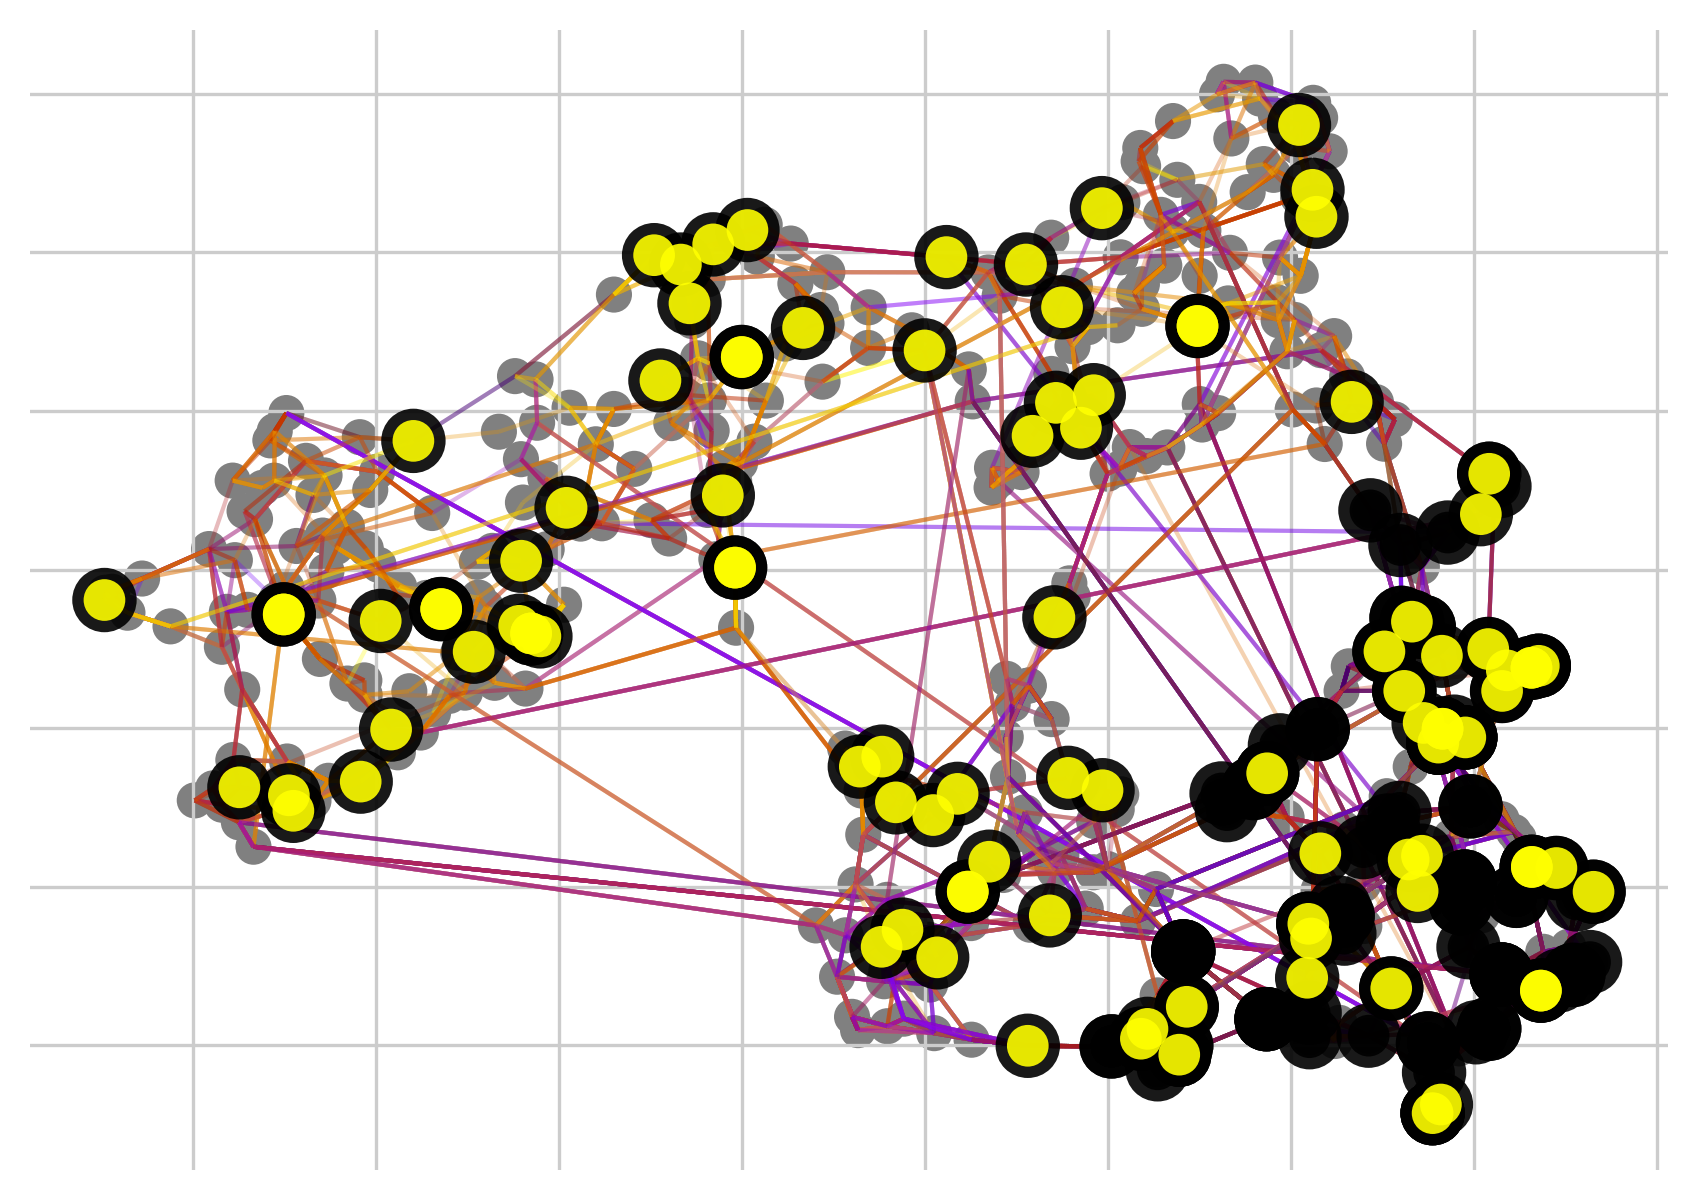

In [15]:
ck.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={SELECTED_LOUVAIN: CLUSTER_OF_ORIGIN},
    basis="X_umap",
    legend_loc="bottom",
    dpi=150,
)

In [16]:
# Combine with the PseudotimeKernel PseudotimeKernel from above
combined_kernel = 0.2 * pk + 0.8 * ck
combined_kernel

(0.2 * PseudotimeKernel[n=399, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.8 * ConnectivityKernel[n=399, dnorm=True, key='connectivities'])

Simulating `100` random walks of maximum length `100`


100%|██████████| 100/100 [00:00<00:00, 124.67sim/s]

    Finish (0:00:00)


Plotting random walks


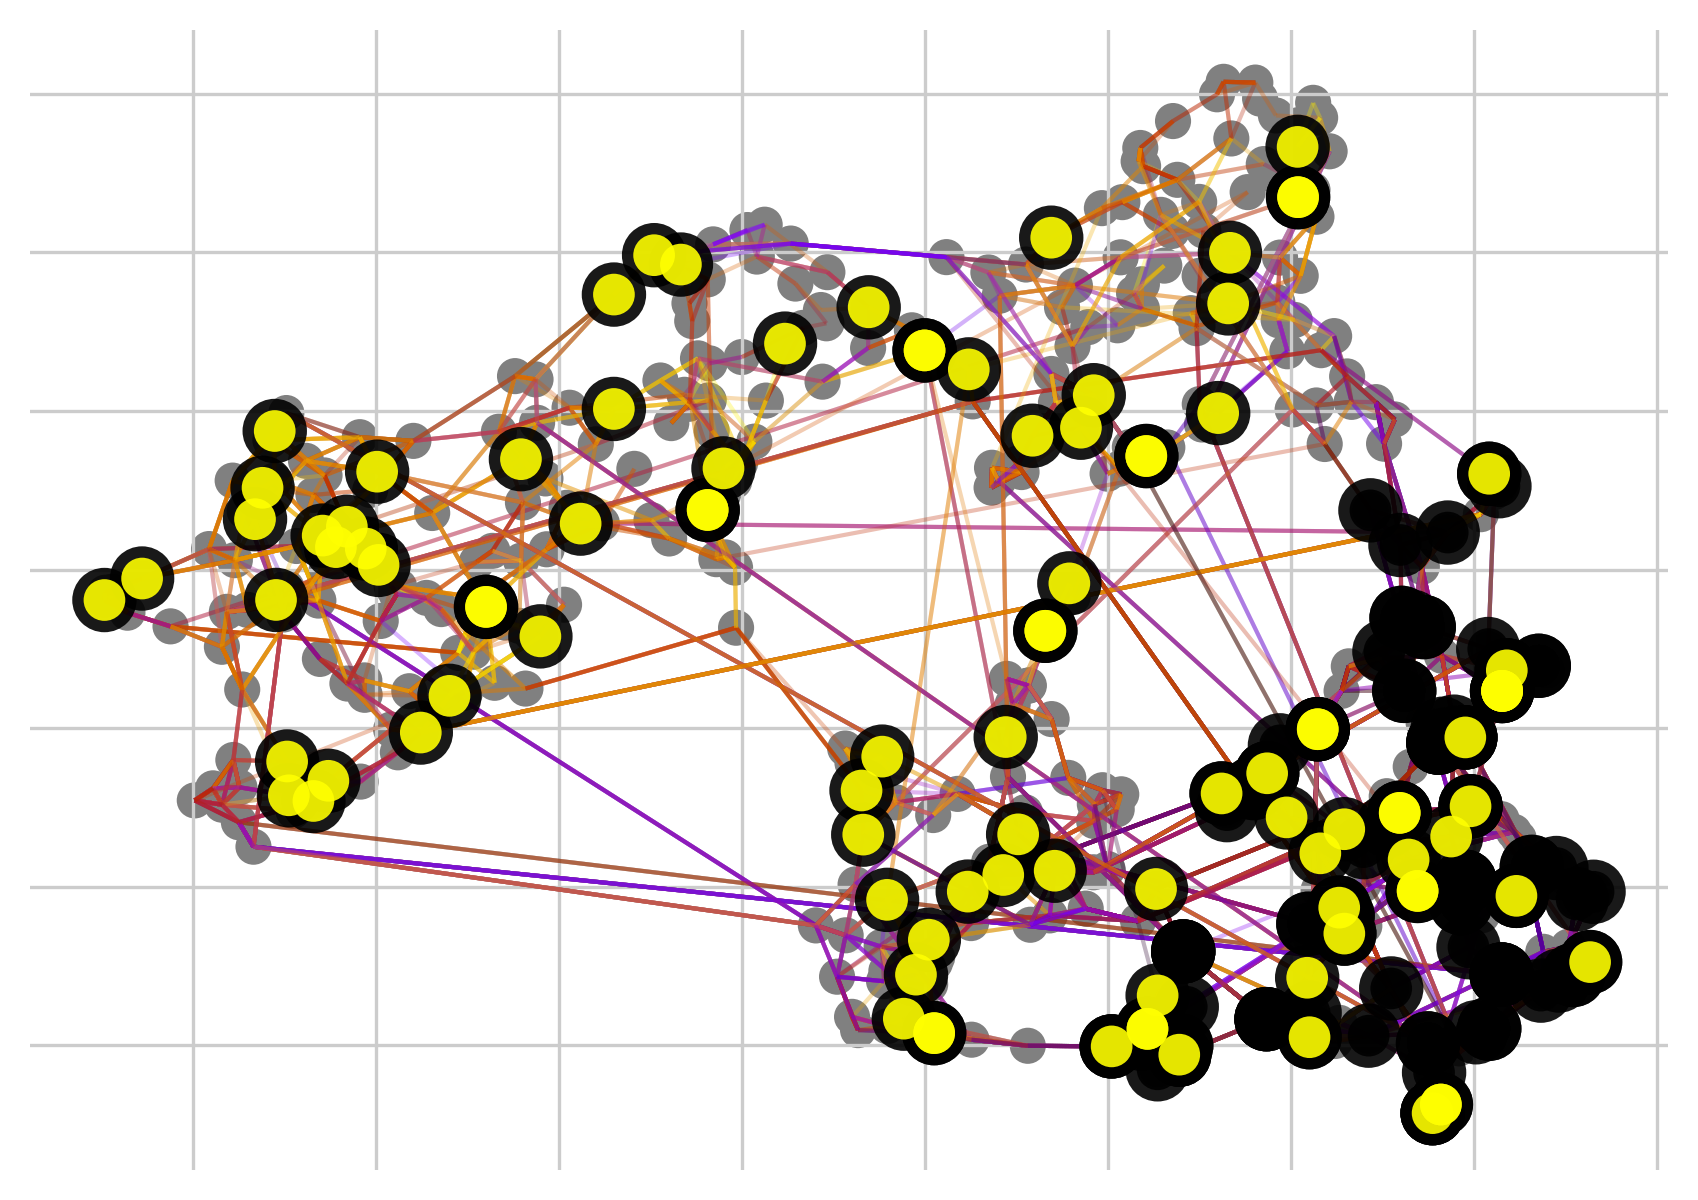

In [17]:
combined_kernel.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={SELECTED_LOUVAIN: CLUSTER_OF_ORIGIN},
    basis="X_umap",
    legend_loc="bottom",
    dpi=150,
)

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)


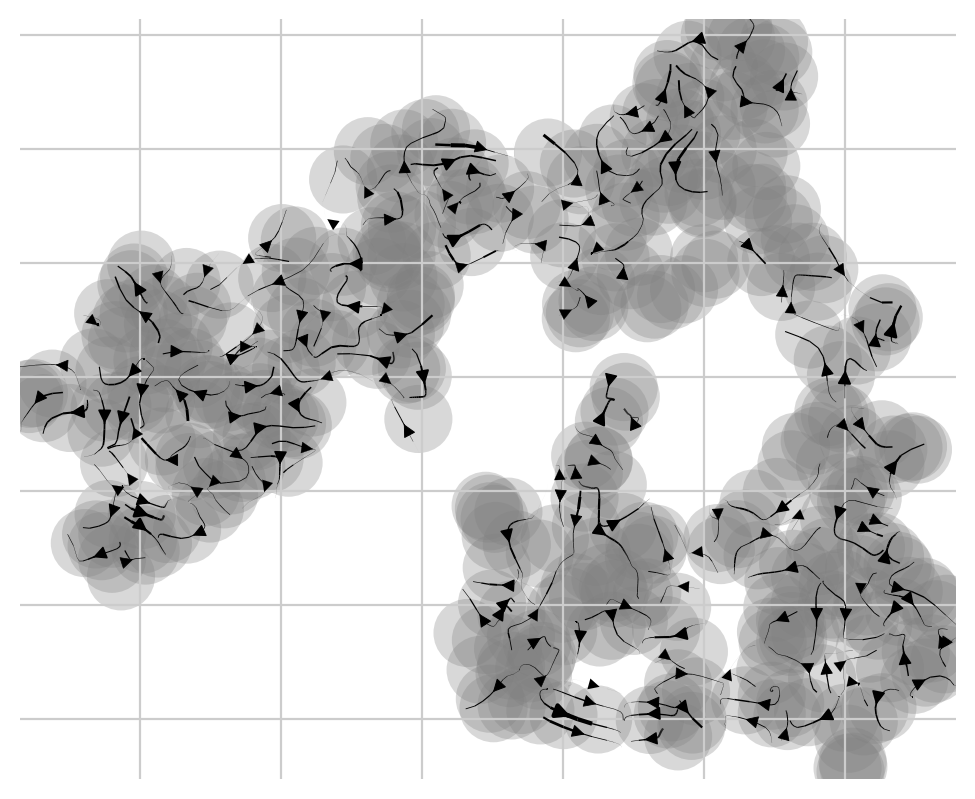

In [18]:
rcParams['figure.figsize']=(6,5)
combined_kernel.plot_projection()

In [19]:
# write kernel to adata
pk.write_to_adata()

In [20]:
adata

AnnData object with n_obs × n_vars = 399 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'hvg', 'iroot', 'log1p', 'louvain', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.2_sizes', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r0.5_colors', 'louvain_r1.0_colors', 'louvain_r1.0_sizes', 'louvain_r1_colors', 'louvain_r2.0_colors', 'louvain_r2.5_colors', 'louvain_r

In [21]:
# read kernel from adata
pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
pk_new

PseudotimeKernel[n=399, dnorm=False, scheme='hard', frac_to_keep=0.3]

In [22]:
# # Write kernel to a file
# pk.write_to_adata()
# adata.write(os.path.join(output_path, "kernels.h5ad"))
# # Read kernale
# adata = sc.read(os.path.join(output_path, "kernels.h5ad"))
# pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
# pk_new

# Working with estimators
Estimators take a kernel object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that represent the slow-time scale dynamics of the process. A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in cellrank.estimators:

CFLARE: Clustering and Filtering Left And Right Eigenvectors. Heuristic method based on the spectrum of the transition matrix.

GPCCA: Generalized Perron Cluster Cluster Analysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates,

In [23]:
from cellrank.estimators import GPCCA

g = GPCCA(pk_new)
print(g)

GPCCA[kernel=PseudotimeKernel[n=399], initial_states=None, terminal_states=None]


# Identify initial & terminal states
Fit the estimator to compute macrostates of cellular dynamics; these may include initial, terminal and intermediate states

In [24]:
g.fit(n_states=5, cluster_key=SELECTED_LOUVAIN)


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `5` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


GPCCA[kernel=PseudotimeKernel[n=399], initial_states=None, terminal_states=None]

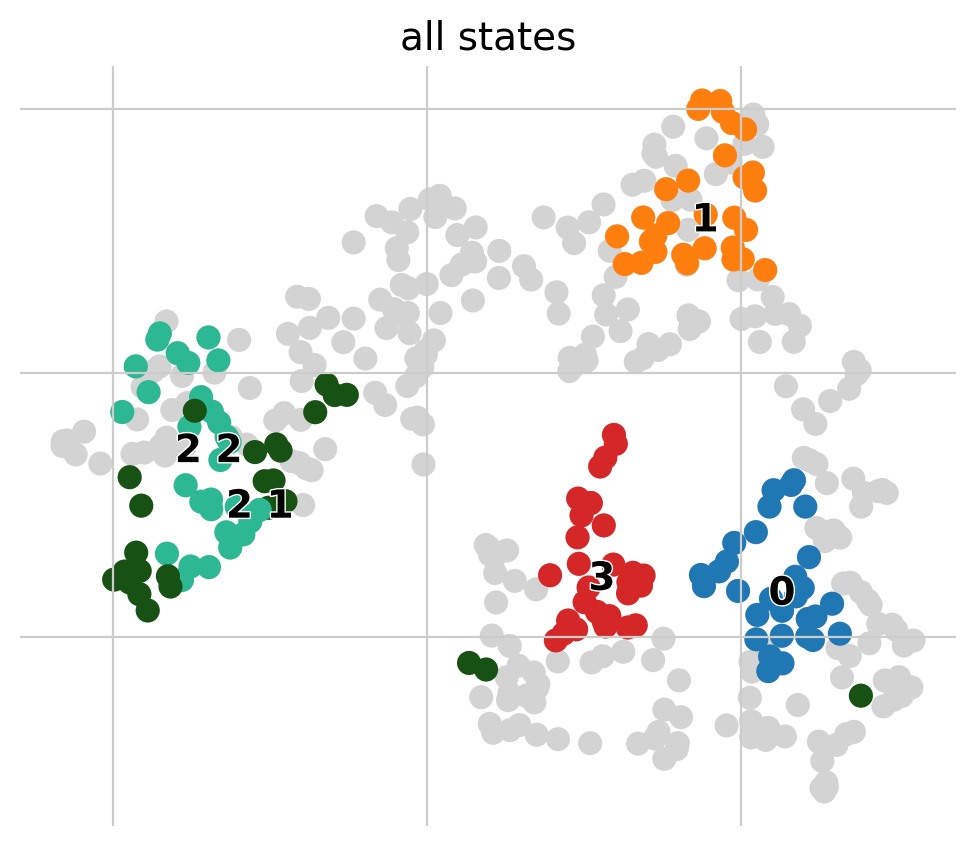

In [25]:
g.plot_macrostates(which="all")

For each macrostate, the algorithm computes an associated stability value. Let’s use the most stable macrostates as terminal states

In [26]:
g.predict_terminal_states(n_cells=5)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


GPCCA[kernel=PseudotimeKernel[n=399], initial_states=None, terminal_states=['0', '1', '2_1', '2_2', '3']]

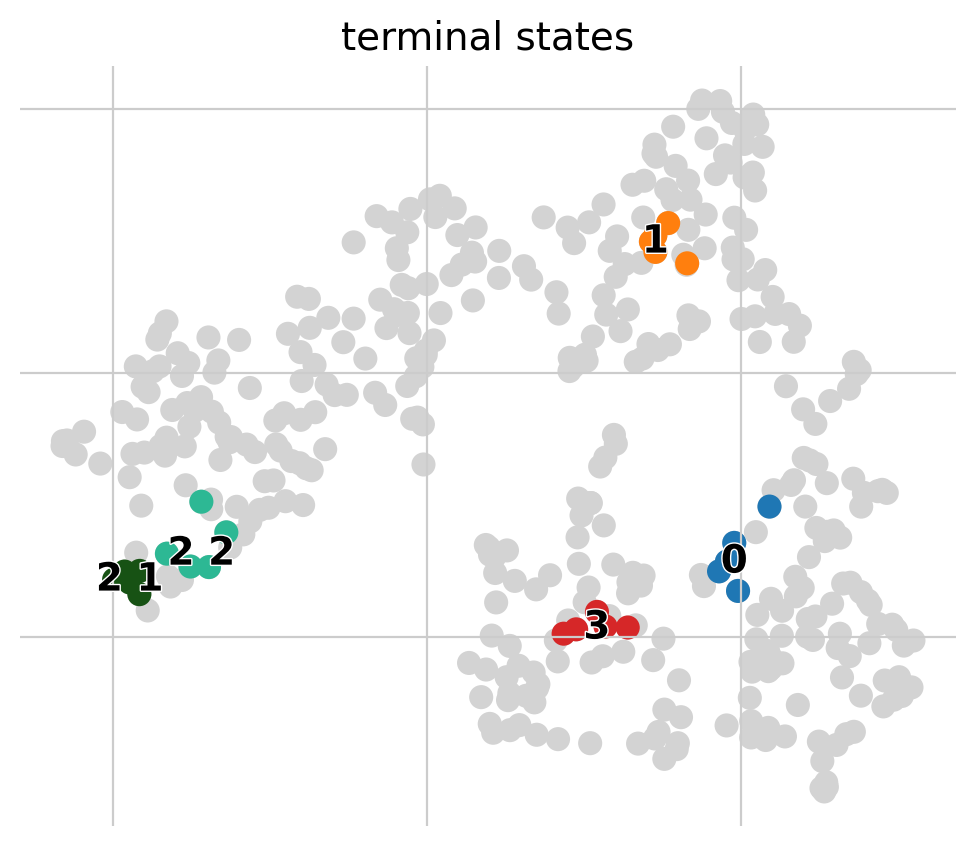

In [27]:
g.plot_macrostates(which="terminal")

## Compute fate probabilities and driver genes
how likely each cell is to reach each terminal state<br>
each cell is colored according to its most likely fate; color intensity reflects the degree of lineage priming

In [28]:
g.compute_fate_probabilities()


Computing fate probabilities
Defaulting to `'gmres'` solver.


100%|██████████| 5/5 [00:00<00:00, 65.68/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


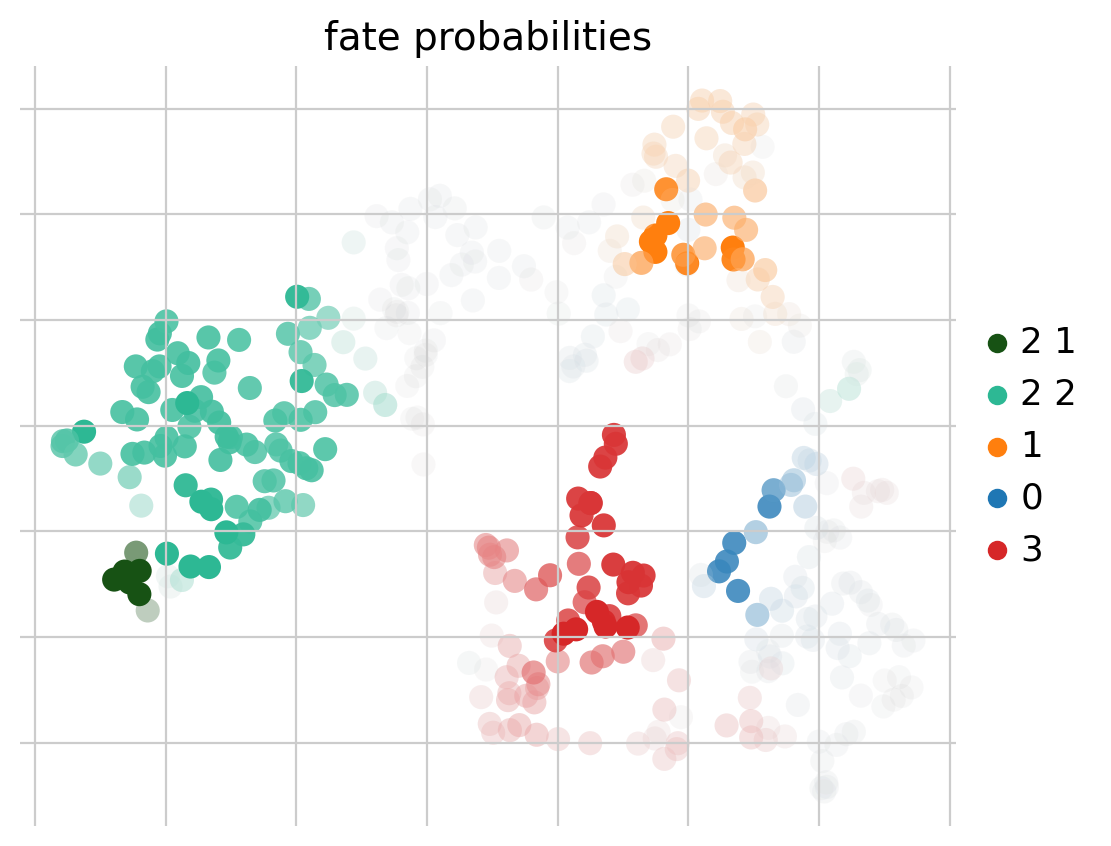

In [29]:
g.plot_fate_probabilities(legend_loc="right")

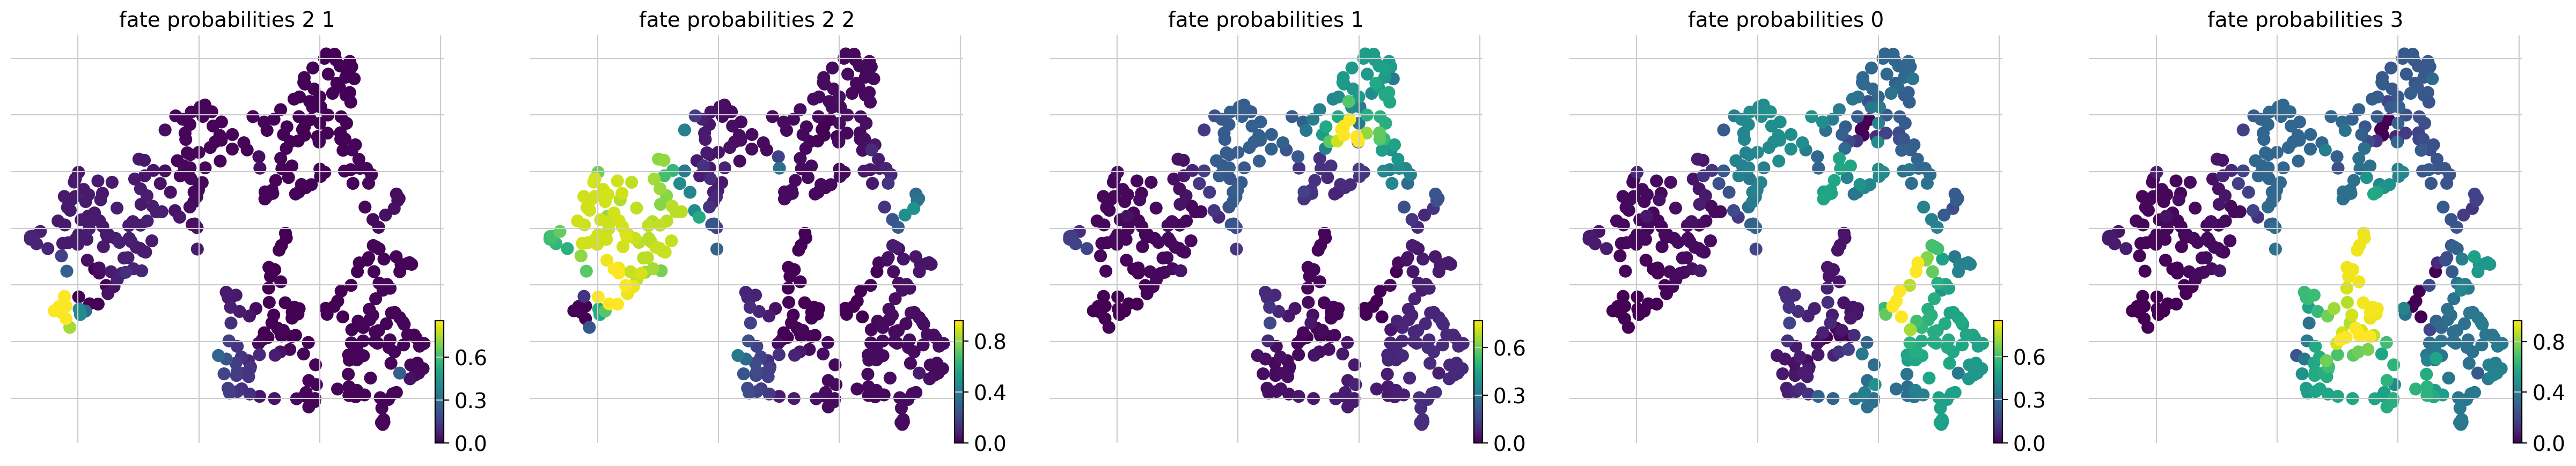

In [30]:
g.plot_fate_probabilities(same_plot=False)

### Circular projection
Each dot represents a cell, colored by cluster labels.<br>Cells are arranged inside the circle according to their fate probabilities;<br>fate biased cells are placed next to their corresponding corner while naive cells are placed in the middle

Solving TSP for `5` states


/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


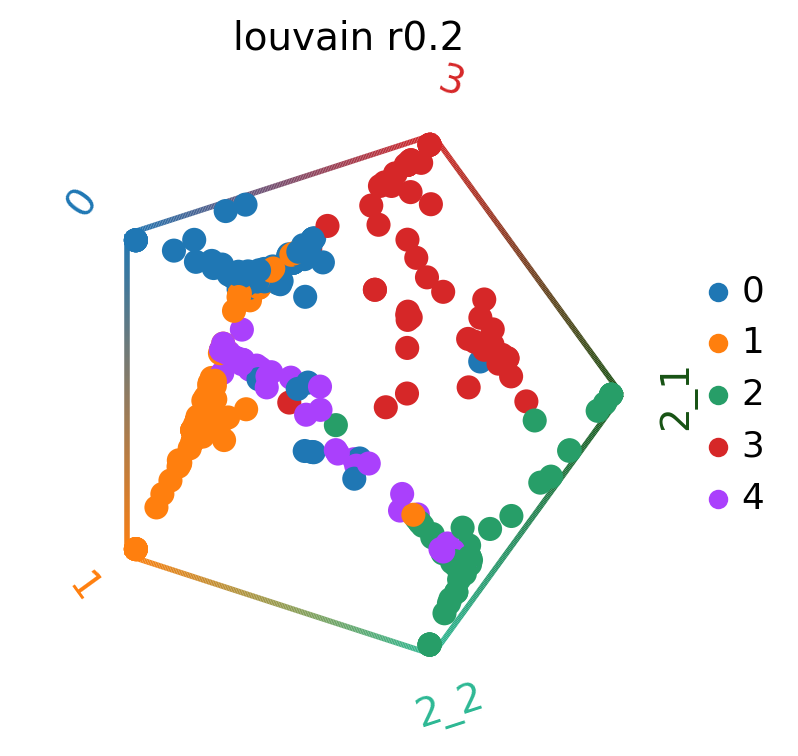

In [31]:
cr.pl.circular_projection(adata, keys=SELECTED_LOUVAIN, legend_loc="right")

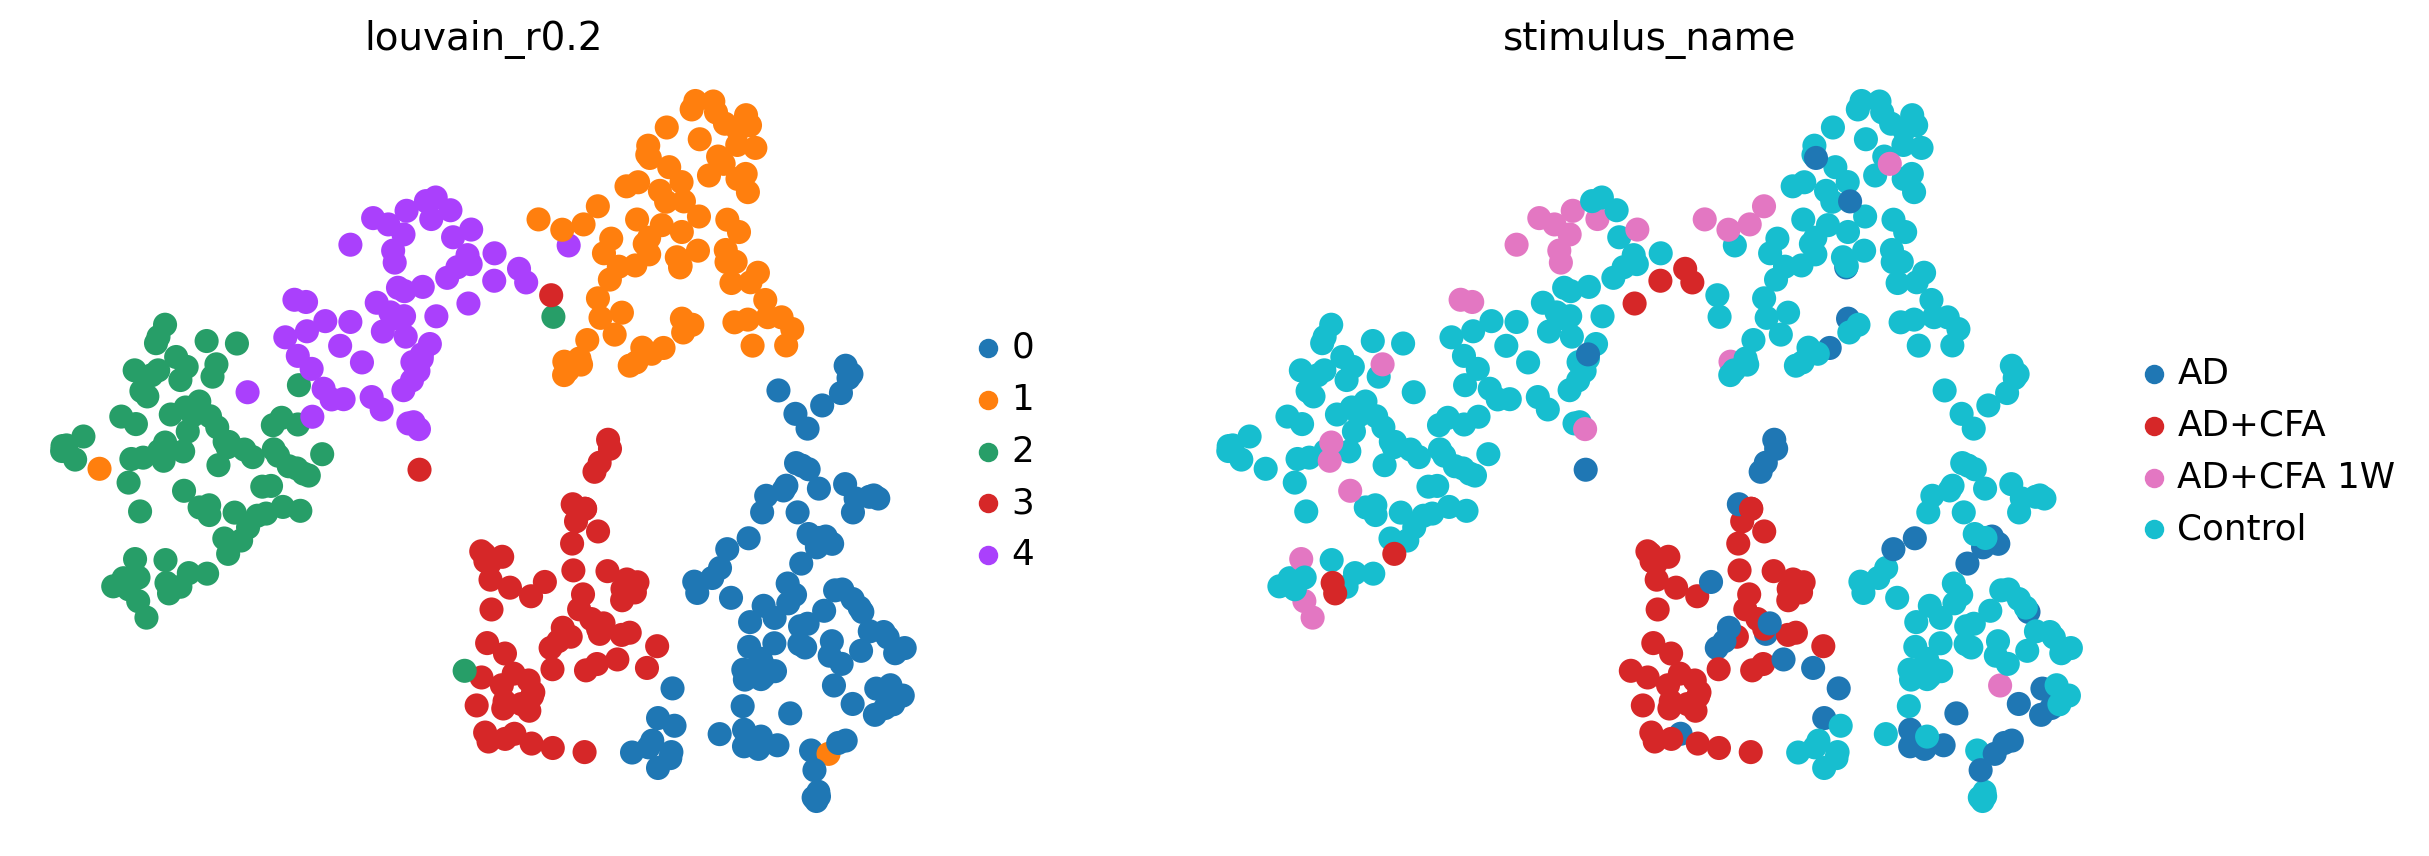

In [32]:
# Remind clusters and stimuli
sc.pl.umap(adata, color=[SELECTED_LOUVAIN, 'stimulus_name'], groups=['0','1','2','3','4','AD','AD+CFA','AD+CFA 1W','Control'],use_raw=False)

In [33]:
adata.var_names_make_unique()
del adata.raw

In [34]:
states = ["0", "1", "2", "3", "4"]

/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

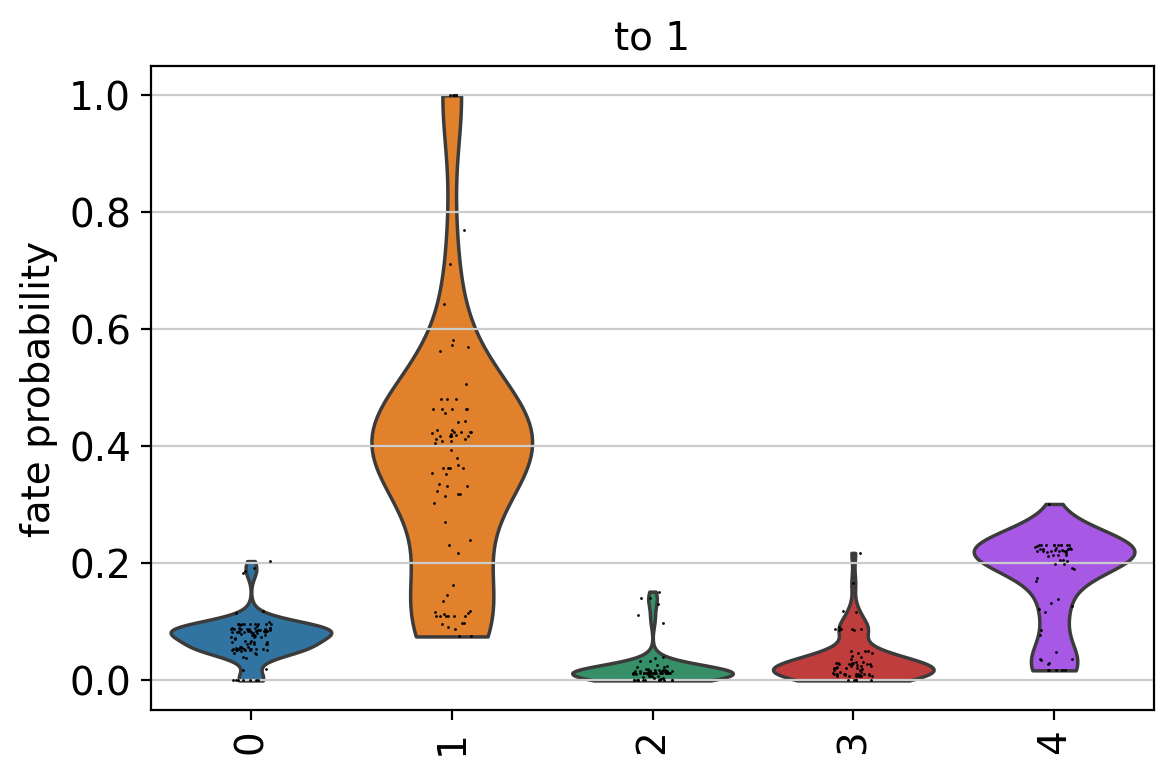

In [35]:
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=["1"],
    cluster_key=SELECTED_LOUVAIN,
    clusters=states
)

/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

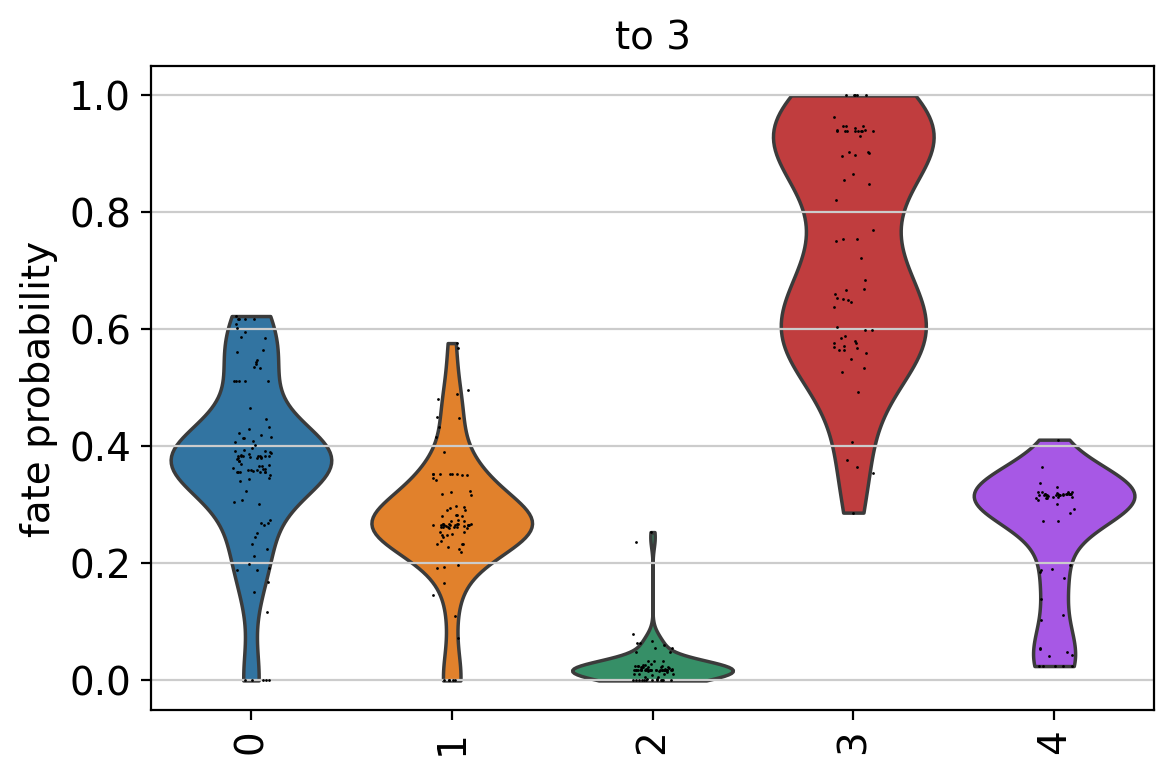

In [36]:
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=["3"],
    cluster_key=SELECTED_LOUVAIN,
    clusters=states
)

/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

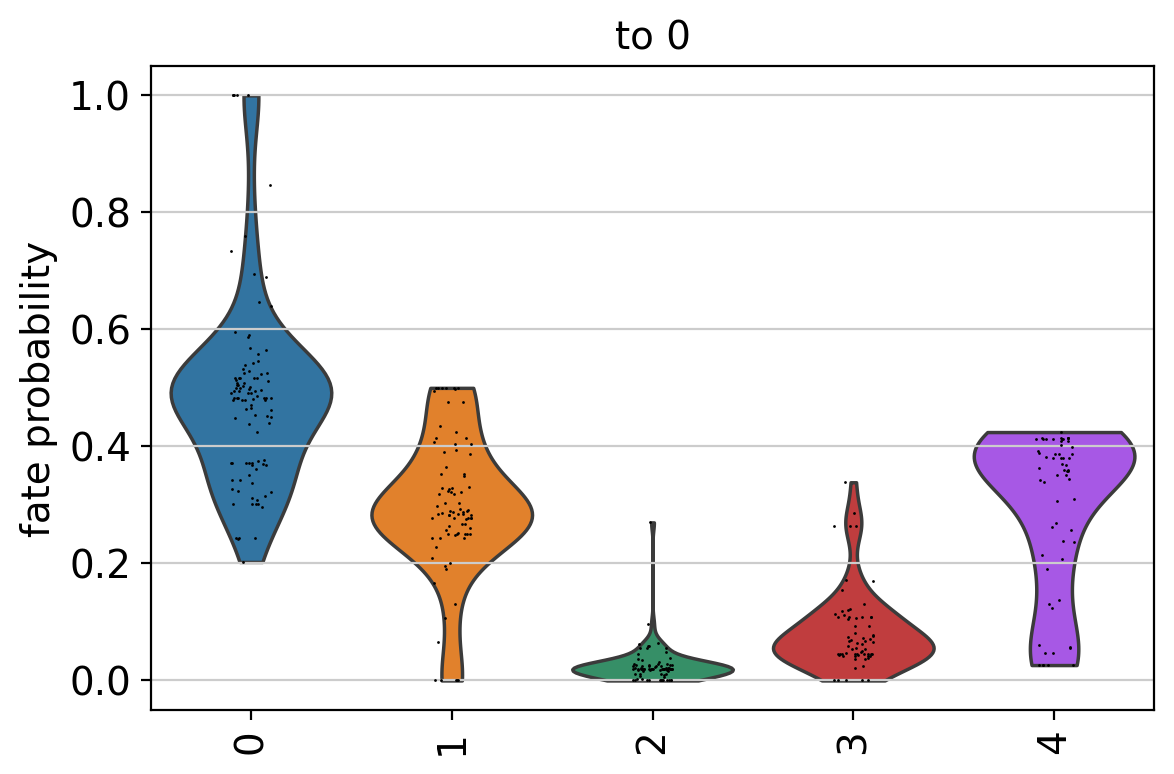

In [37]:
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=["0"],
    cluster_key=SELECTED_LOUVAIN,
    clusters=states
)

/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

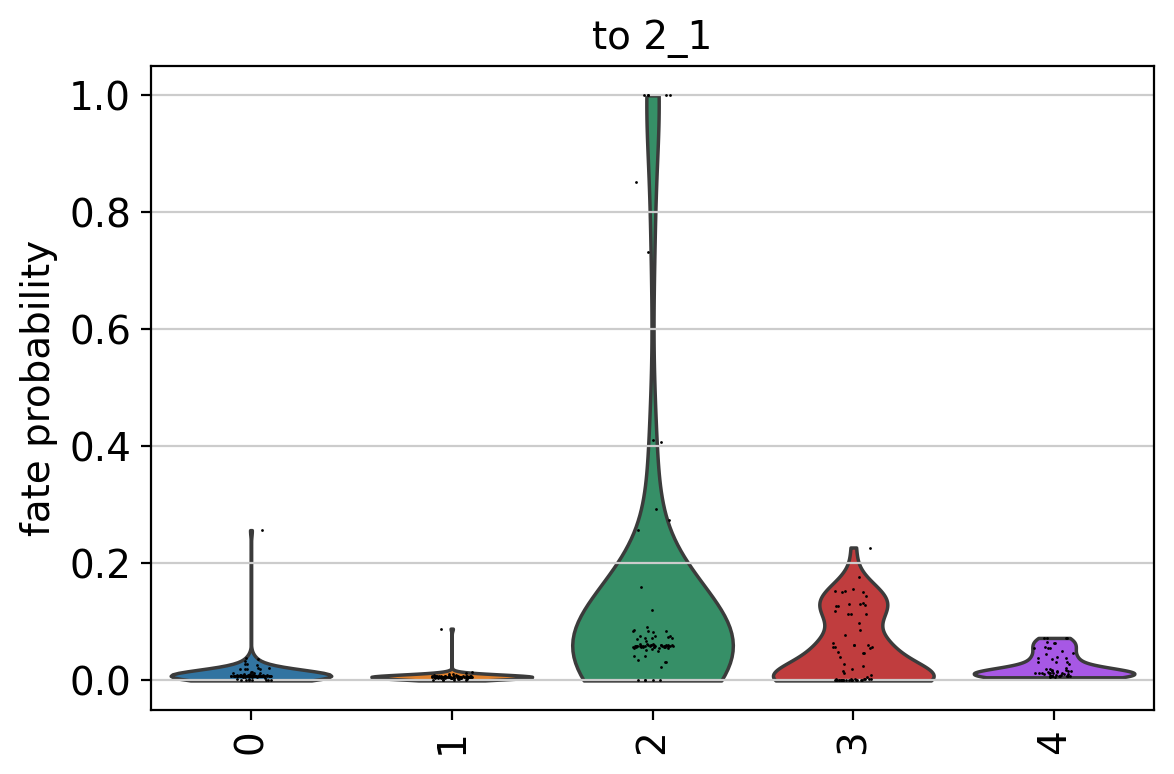

In [38]:
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=["2_1"],
    cluster_key=SELECTED_LOUVAIN,
    clusters=states
)

/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ilosz01/anaconda3/envs/scsPy39/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

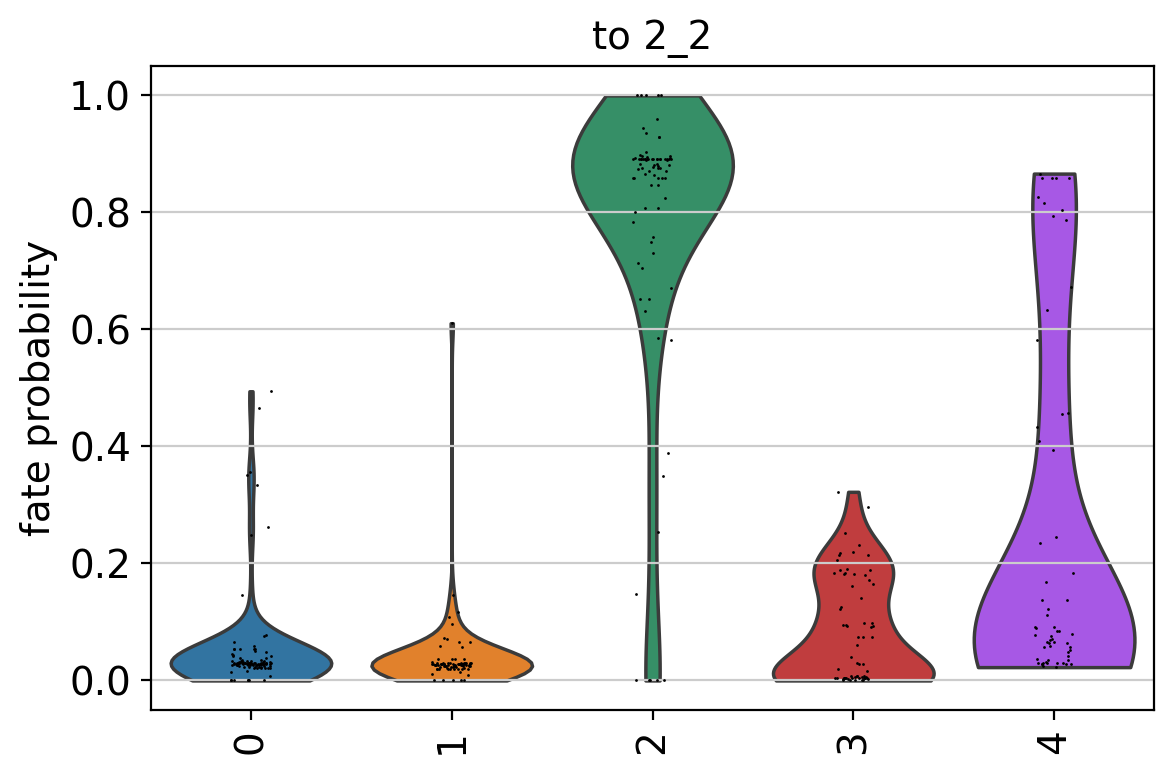

In [39]:
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=["2_2"],
    cluster_key=SELECTED_LOUVAIN,
    clusters=states
)